In [1]:
import numpy as np
import pandas as pd
import h5py
import os
import imageio
from skimage import color
from skimage import transform
from skimage.color import rgb2gray
from skimage.feature import hog
from scipy.fftpack import dct
import matplotlib.pylab as plt
import seaborn as sn

In [2]:
class Model():
    # Constructor 
    def __init__ (self, id = -1, name = '', model_name = ''):

        if model_name != '':
            with h5py.File(model_name, 'r') as hf:
                self.__id__   = np.int64(hf.get('id'))
                dset = hf.get('name')
                self.__name__ = dset.attrs['name']
                self.__data__  = np.array(hf.get('vects'))
        else:
            self.__id__   = id
            self.__data__ = []
            self.__name__ = name
        
    # Stores the model in a file within the specified directory 
    def save (self, model_name):
        
        hf = h5py.File(model_name, 'w')
        hf.create_dataset('vects', data=self.__data__)
        hf.create_dataset('id'   , data=self.__id__)
        
        dt = h5py.special_dtype(vlen=bytes)   # http://docs.h5py.org/en/latest/strings.html
        dset = hf.create_dataset("name", (100,), dtype=dt)
        dset.attrs["name"] = self.__name__
        hf.close()

        
    # Adds a feature vector to the model (in vector _data).
    def add (self, vec):
        self.__data__.append(vec)
        
    # Returns the vector size (number of faces in the model)
    def size(self):
        return len(self.__data__)
    
    # Access the feature vector of a given face 
    def __call__(self, num_vec):
        return self.__data__[num_vec]
    
    # Returns the numerical identifier
    def id(self):
        return self.__id__

    def name(self):
        return self.__name__


# Read all vectors in models_dir into an array
def load_models(models_dir):

    models = []
    for dirName, subdirList, fileList in os.walk(models_dir):
        for fname in sorted(fileList):
            extension = os.path.splitext(fname)[1]
            if extension == '.bin':
                print ('Reading model {}/{}'.format(dirName, fname))
                models.append(Model(model_name = '{}/{}'.format(dirName, fname)))

    return models


In [6]:
##########################################
# TODO: Add functions to extract features
##########################################

def histogram(ima, num_coeffs=100, width=40):

    # Convert to grayscale if color
    if len(ima.shape) == 3:
        ima = color.rgb2gray(ima)

    # Resize to width x width
    x = transform.resize(ima, (width,width))

    coeffs = ima.flatten()
    
    return np.histogram(coeffs, bins=num_coeffs)[0]


def DCT_2D(ima, num_coeffs=100, width=40): 

    # implement 2D DCT
    def dct2(a):
        return dct(dct(a.T, norm='ortho').T, norm='ortho')

    im = rgb2gray(ima) 
    im = transform.resize(im, (width, width))
    imF = dct2(im)

    zigzag = np.concatenate([np.diagonal(imF[::-1,:], i)[::(2*(i % 2)-1)] for i in range(1-imF.shape[0], imF.shape[0])])
    
    return zigzag[0:num_coeffs]


def HOG(ima, width=40):

    ima = color.rgb2gray(ima)
    ima = transform.resize(ima, (width, width))

    fd = hog(ima, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(3, 3), block_norm='L2-Hys', visualize=False, transform_sqrt=False)

    return fd

In [7]:
##########################################
# TODO: Add functions to classify 
##########################################


# hard kNN
def kNN (vect, models, k):
    
    distances = []
    
    for ii in range(len(models)):
        for jj in range(models[ii].size()):
            dist = np.linalg.norm(models[ii](jj) - vect)   
            distances.append([dist,ii])
            
    distances = sorted(distances, key = lambda x: x[0])
    distances = distances[0:k]
    ind=[distance[1] for distance in distances]
    auxiliar = np.zeros(len(models))
    
    for index in ind:
        auxiliar[index]=auxiliar[index]+1
        
    auxiliar=list(auxiliar)
    return auxiliar.index(max(auxiliar))


# soft kNN
def w_kNN (vect, models, k):
    
    distances = []
    
    for ii in range(len(models)):
        for jj in range(models[ii].size()):
            dist = np.linalg.norm(models[ii](jj) - vect)   
            distances.append([dist,ii])
            
    distances = sorted(distances, key = lambda x: x[0])
    distances = distances[0:k]
    ind=[distance[1] for distance in distances]
    auxiliar = np.zeros(len(models))
    
    max_dist = max(distances, key = lambda x: x[0])[0]
    
    for count, index in enumerate(ind):
        auxiliar[index]=auxiliar[index]+max_dist/distances[count][0]
        
    auxiliar=list(auxiliar)
    return auxiliar.index(max(auxiliar))

In [8]:
# Create models for all images

if __name__ == '__main__':

    path_name = 'train/'  # directory with input images
    output_dir = 'models/'  # directory with output models
    num_coeffs = 350 # TODO: Choose the number of coefficients to keep for feature vectors [default: 100]
    width = 40  # TODO: Choose the resizing of the images [default: 40]

    print (path_name)
    print (output_dir)
    print (num_coeffs)
    print (width)

    ident = 0
    model_dict = {}


    # Create a dictionary with the different persons
    for dirName, subdirList, fileList in os.walk(path_name):
        print('Found directory: %s' % dirName)
        for fname in sorted(fileList):
            base, extension = os.path.splitext(fname)
            person_name = os.path.basename(dirName)

            # If model has not been created, create it
            if not(person_name in model_dict):
                model_dict[person_name] = Model(id = ident, name = person_name)
                ident = ident + 1

            # Add images to model
            if extension == '.jpg' or extension == '.JPG' or extension == '.png' or extension == '.PNG':

                # Read image and convert it to GRAY
                ima = imageio.imread('{}/{}'.format(dirName,fname))

                ###########################################
                # TODO: Create feature and use it here
                ###########################################
                
#                 histogram
#                 coeffs = histogram(ima, num_coeffs, width)
                
#                 # DCT
#                 coeffs = DCT_2D(ima, num_coeffs, width)
                
                # HOG
                coeffs = HOG(ima, width)
                
                # Add to model
                model_dict[person_name].add(coeffs)


    # Save all models
    for name in model_dict:
        model_name = '{}/{}_model.bin'.format(output_dir, name)
        model_dict[name].save(model_name)

train/
models/
350
40
Found directory: train/
Found directory: train/Agnes_Marques
Found directory: train/Daniel_Sirera
Found directory: train/JoanCarles_Peris
Found directory: train/Joan_Saura
Found directory: train/Jose_Montilla
Found directory: train/Miquel_Iceta
Found directory: train/Nuria_Sole
Found directory: train/Ramon_Pellicer
Found directory: train/Raquel_Sans
Found directory: train/Xavi_Coral


In [9]:
from sklearn.metrics import confusion_matrix       # Advanced functionality: compute confusion matrix
from sklearn.metrics import classification_report  # Advanced functionality: provide classification report

images_path = 'test/'  # directory with input images
models_dir = 'models/'  # directory with input models
k = 3 # TODO: Choolse value of k (number of neightbors to use)  [default: 3]
width = 40  # TODO: Choose size to rescale the images     [default: 40]
print(k)
model_list = load_models(models_dir)

correctly_classified = 0
total_images         = 0

# All models should have consistent feature vectors. 
# It should be safe to take the lenght of the first vector
num_coeffs = len(model_list[0](0))
    
y_true = [] # True labels.      Necessary if computing the confusion matrix
y_pred = [] # Predicted labels. Necessary if computing the confusion matrix
    
# Read all images in the given folder. All images should be cropped faces from the same individual
for dirName, subdirList, fileList in os.walk(images_path):
    for fname in sorted(fileList):
        extension = os.path.splitext(fname)[1]
        if extension == '.jpg' or extension == '.JPG' or extension == '.png' or extension == '.PNG':
            total_images = total_images + 1
                
            ima = imageio.imread('{}/{}'.format(dirName,fname))

            ##########################################
            # TODO: Extract the same feature as models
            ##########################################
            
#             # histogram
#             coeffs = histogram(ima, num_coeffs, width)
                
#             # DCT
#             coeffs = DCT_2D(ima, num_coeffs, width)
                
            # HOG
            coeffs = HOG(ima, width)
          

            ##############################################################################
            # TODO: Classify according to the features extracted and the models computed
            ##############################################################################
            best_id = w_kNN(coeffs, model_list, k)     

                
            # Test/validation images should be stored in directories named according to the person name.
            # (the name of the directory is the label for this class)
            ground_truth_name = os.path.basename(dirName)

            y_true.append(ground_truth_name)
            y_pred.append(model_list[best_id].name())
                
            if model_list[best_id].name() == ground_truth_name:
                correctly_classified = correctly_classified + 1
            else:
                print ('ERROR: Image {}, true name = {}, hypothesis name = {}'.format(fname, ground_truth_name, model_list[best_id].name()))

print ('Total classification error: {0:.2f}%'.format((1.0 - correctly_classified/total_images)*100.0))  # Basic reporting

# Advanced reporting:
print (confusion_matrix(y_true, y_pred))
print (classification_report(y_true, y_pred, digits = 3))

3
Reading model models//Agnes_Marques_model.bin
Reading model models//Daniel_Sirera_model.bin
Reading model models//JoanCarles_Peris_model.bin
Reading model models//Joan_Saura_model.bin
Reading model models//Jose_Montilla_model.bin
Reading model models//Miquel_Iceta_model.bin
Reading model models//Nuria_Sole_model.bin
Reading model models//Ramon_Pellicer_model.bin
Reading model models//Raquel_Sans_model.bin
Reading model models//Xavi_Coral_model.bin
ERROR: Image 01_37_08_08_crop.jpg, true name = Daniel_Sirera, hypothesis name = Jose_Montilla
ERROR: Image 01_39_49_13_crop.jpg, true name = Daniel_Sirera, hypothesis name = Jose_Montilla
ERROR: Image 02_02_00_07_crop.jpg, true name = Jose_Montilla, hypothesis name = Daniel_Sirera
ERROR: Image 02_00_35_09_crop.jpg, true name = Miquel_Iceta, hypothesis name = Jose_Montilla
ERROR: Image 00_13_48_04_crop.jpg, true name = Nuria_Sole, hypothesis name = Agnes_Marques
ERROR: Image 00_17_57_13_crop.jpg, true name = Nuria_Sole, hypothesis name = Ram

<AxesSubplot:>

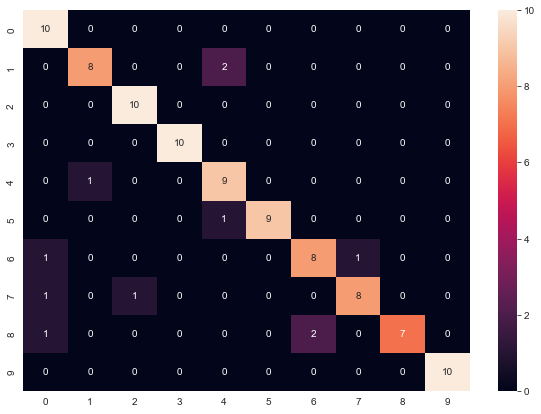

In [10]:
array = confusion_matrix(y_true, y_pred)

x = array.shape[0]
y = array.shape[1]

df_cm = pd.DataFrame(array, index = [i for i in range(0,x)],
                  columns = [i for i in range(0,y)])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)